<a href="https://colab.research.google.com/github/zhpinkman/sentiment-analysis-digikala/blob/master/Digikala_comments_sentiment_analysis_word2vec_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the essential packages for the project

In [74]:
import numpy as np
import pandas as pd
import fasttext.util
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

model's parameters

In [80]:
embedding_vector_length = 300
sentences_max_length = 70
lstm_units = 50

In [1]:
!git clone https://github.com/facebookresearch/fastText.git

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 34.38 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.


In [4]:
!sudo pip install fastText/.
!cd fastText
fasttext.util.download_model('fa', if_exists='ignore')
ft = fasttext.load_model('cc.fa.300.bin')

inspecting the result of getting nearest neighbors using the fasttext model on certain words.

In [8]:
ft.get_nearest_neighbors('طلا')

[(0.694230854511261, 'طلای'),
 (0.6849290728569031, 'طلاو'),
 (0.6164087057113647, 'طلابه'),
 (0.6109494566917419, 'نقره'),
 (0.5962421298027039, 'جواهر'),
 (0.5737359523773193, 'سکه'),
 (0.5678431987762451, 'طلاوجواهر'),
 (0.5546823143959045, 'وجواهر'),
 (0.5541793704032898, 'طلادر'),
 (0.5481424331665039, 'طلاسکه')]

In [9]:
ft.get_nearest_neighbors('ماشین')

[(0.6747990250587463, 'ازماشین'),
 (0.6507582068443298, 'ماشینهای'),
 (0.6458106637001038, 'وماشین'),
 (0.6424431800842285, 'ماشین\u200cهای'),
 (0.6340875625610352, 'ماشینماشین'),
 (0.629118025302887, 'تولیدماشین'),
 (0.6223403215408325, 'اتومبیل'),
 (0.6012367606163025, 'خریدماشین'),
 (0.5977076292037964, 'است.ماشین'),
 (0.5947739481925964, 'ماشین\xad')]

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!unzip archive.zip

Archive:  archive.zip
  inflating: data.csv                


In [57]:
df = pd.read_csv('data.csv')
df.head(3)

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1


In [58]:
text_lengths = df['Text'].apply(lambda x: len(x.split(' '))).values

In [59]:
print('mean of the sentences length: {}'.format(np.mean(text_lengths)))
print('max of the sentences length: {}'.format(np.max(text_lengths)))

mean of the sentences length: 56.590616375344986
max of the sentences length: 1347


In [60]:
df.drop(columns=['Score'], axis=1, inplace=True)

In [61]:
df['Suggestion'] = df['Suggestion'].replace(2, 1)
df['Suggestion'] = df['Suggestion'].replace(3, 0)

In [62]:
df['Suggestion'].unique()

array([1, 0])

In [63]:
df.head(5)

,Text,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,1
1,خرید این محصول رو توصیه میکنم,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,1


In [64]:
df['Suggestion'].value_counts()

1    2801
0     460
Name: Suggestion, dtype: int64

In [65]:
df_minority = df[df['Suggestion']==0]
df_majority = df[df['Suggestion']==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=103) # reproducible results
 
# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])

In [66]:
df['Suggestion'].value_counts()

1    2801
0    2801
Name: Suggestion, dtype: int64

In [73]:
texts = df.Text.values
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(texts)

vocab_size = len(tokenizer.word_index) + 1
print('vocab size: {}'.format(vocab_size))

encoded_texts = tokenizer.texts_to_sequences(texts)

padded_sequence = pad_sequences(encoded_texts, maxlen=sentences_max_length, padding='post')
print('number of padded sequences and its shape:')
print(padded_sequence.shape)

vocab size: 12125
number of padded sequences and its shape:
(5602, 70)


In [76]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequence, df.Suggestion.values, test_size=0.3, shuffle=True)

extracting the embedding form of every word in the sequences to take advantage of them in the embedding layer. 

In [77]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
  embedding_vector = ft.get_word_vector(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

Buliding the model

In [108]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=sentences_max_length, weights=[embedding_matrix], trainable=True))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(lstm_units, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 70, 300)           3637500   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 70, 300)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 3,707,751
Trainable params: 3,707,751
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
 history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
98/98 [==============================] - 16s 138ms/step - loss: 0.6933 - accuracy: 0.5132 - val_loss: 0.6838 - val_accuracy: 0.5554
Epoch 2/30
98/98 [==============================] - 13s 134ms/step - loss: 0.6783 - accuracy: 0.5625 - val_loss: 0.6628 - val_accuracy: 0.5694
Epoch 3/30
98/98 [==============================] - 13s 133ms/step - loss: 0.6453 - accuracy: 0.5857 - val_loss: 0.5894 - val_accuracy: 0.6624
Epoch 4/30
98/98 [==============================] - 13s 133ms/step - loss: 0.5537 - accuracy: 0.7136 - val_loss: 0.5260 - val_accuracy: 0.7580
Epoch 5/30
98/98 [==============================] - 13s 133ms/step - loss: 0.4921 - accuracy: 0.7719 - val_loss: 0.4475 - val_accuracy: 0.8089
Epoch 6/30
98/98 [==============================] - 13s 133ms/step - loss: 0.4452 - accuracy: 0.8071 - val_loss: 0.4076 - val_accuracy: 0.8357
Epoch 7/30
98/98 [==============================] - 13s 134ms/step - loss: 0.3996 - accuracy: 0.8402 - val_loss: 0.3507 - val_accuracy: 0.8675

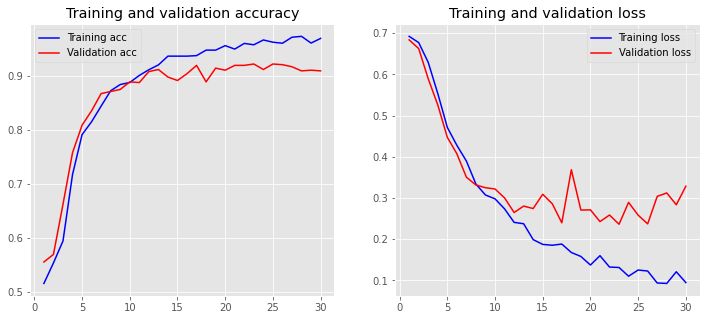

In [110]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [111]:
model.evaluate(X_test, y_test)

53/53 [==============================] - 1s 17ms/step - loss: 0.3354 - accuracy: 0.9060


[0.3353801369667053, 0.9060083031654358]